<a href="https://colab.research.google.com/github/freguti/progettoML/blob/main/ProgettoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP:

1 - Dovremo prendere, per ogni super categoria, tutte le annotazioni e associarle alla super categoria corrispondente.

2 -  fare il fine-tuning del modello di CTRL tramite le annotazioni associate alla super categoria e generare del testo

    2.1 - modficare i control code durante la fase di fine tuning, in modo tale da inserire i nostri.  

3 - Valutare il testo generato tramite una versione modificata di TexyGen.

Dubbi: 
- bisogna usare le categorie o le super categorie? 

Commenti:

Al momento ho creato una demo che mostra le super categorie e prende le annotazioni di una categoria fissa.

CTRL sono riuscito solo a farlo girare in modalità low memory, ma è molto più inefficiente

#Prepare environment

In [1]:
from google.colab import drive
from pycocotools.coco import COCO
import os
import subprocess

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb demo coco API
                   
dataDir='/content/drive/MyDrive/Machine Learning/Progetto'
dataType='val2017' 
modelDir = dataDir + '/model/' 
instFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
#annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)

# Prepare Dataset

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(instFile) #modello con le foto e le categorie
coco_ann=COCO(annFile) #modello con le annotazioni

loading annotations into memory...
Done (t=2.32s)
creating index...
index created!
loading annotations into memory...
Done (t=1.38s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

supernms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(supernms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
kitchen appliance sports person outdoor food indoor furniture electronic accessory vehicle animal


In [ ]:
categoryIds = {} #Dizionario -> Chiave: nome categoria, Valore: id categoria
for cat in nms:
  categoryIds[cat] = coco.getCatIds(catNms=cat)

imagesIds = {} #Dizionario -> Chiave: nome categoria, Valore: id delle immagini della categoria
for (key, val) in categoryIds.items():
  imagesIds[key] = coco.getImgIds(catIds=val)

annotationsIds = {} #Dizionario -> Chiave: nome categoria, Valore: id di tutte le annotazioni di tutte le immagini della categoria
for(key, val) in imagesIds.items():
  annotationsIds[key] = coco_ann.getAnnIds(imgIds=val)

categoryAnnotations = {} #Dizionario -> Chiave: nome categoria, Valore: annotazioni di tutte le immagini della categoria
for (key, val) in annotationsIds.items():
  categoryAnnotations[key] = coco_ann.loadAnns(val)

for (key, val) in categoryAnnotations.items():
  with open("/content/drive/MyDrive/Machine Learning/Progetto/categories/" + key + ".txt", "w") as outfile:
    for elem in val:
      outfile.write(elem['caption'] + "\n")



In [ ]:
# load and display caption annotations
catIds = coco.getCatIds(catNms=['outdoor']); #seleziono le categorie che voglio analizzare
imgIds = coco.getImgIds(catIds=catIds ); #ottengo l'id delle immagini di categoria desiderata
annIds = coco_ann.getAnnIds(imgIds=imgIds); #ottengo l'annotazione relativa all'immagine con le categorie da me scelte [idAnn1,idAnn2,...] 
#TEST
#uso un id fisso
imgAnnIds = coco_ann.getAnnIds(imgIds=[324158,5698]); #ottengo l'annotazione relativa all'immagine con le categorie da me scelte
#FINE TEST
anns = coco_ann.loadAnns(annIds)
coco_ann.showAnns(anns)

# CTRL

##Prepare model

In [5]:
from shutil import copyfile
import gc


lowerMemory = False
mixed = True
project_path = "/content/drive/MyDrive/Machine Learning/Progetto/"
ctrl_path = project_path + "ctrl/"
training_path = ctrl_path + "training_utils/"
model_dir = "seqlen256_v1.ckpt/"
pretrained_model_dir = "model/"
model_name = "model.ckpt-413000.data-00000-of-00001"

def Patch_Keras(old_path = ctrl_path):
  #%cd ctrl_path
  os.chdir(ctrl_path)
  !patch -b /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/keras.py estimator.patch
  #%cd old_path
  os.chdir(old_path)

def init_mixed():
  !pip install transformers
  from transformers import CTRLModel, CTRLConfig
  model = CTRLModel.from_pretrained('ctrl', config = CTRLConfig(n_layer = 10))
  model.save_pretrained(save_directory = project_path + pretrained_model_dir)


def init_no_API():
  os.chdir(project_path) #%cd project_path
  !nvidia-smi
  !pip2 install tensorflow-gpu==1.14 #installo le dipendenze
  prova = training_path + "prova1.txt"
  #!rm -rf ctrl
  !rm -rf prova
  !git clone https://github.com/salesforce/ctrl #clono CTRL
  os.chdir(ctrl_path) #%cd ctrl_path
  if lowerMemory == True:
    Path_Keras(ctrl_path)
    !git checkout lower_memory
  else:
    !pip install torch
    !git checkout master
  !pip2 install fastBPE

  if mixed == False:
    if os.path.isfile(project_path + model_dir + model_name) == False:
      os.chdir(project_path)#%cd project_path
      !pip2 install gsutil #gsutil is a Python application that lets you access Cloud Storage from the command line. You can use gsutil to do a wide range of bucket and object management tasks
      !gsutil -m cp -r gs://sf-ctrl/seqlen256_v1.ckpt . #48 layer
  else:
    print("MIXED @@@@@@@@@@@@@@@@")
    init_mixed()

def generate_no_API():
  #from keras import backend as K
  #config = tf.ConfigProto()
  #config.gpu_options.allow_growth = True
  #config.log_device_placement = True
  #session = tf.Session(config=config)
  #K.set_session(session)
  gc.collect()
  os.chdir(ctrl_path)#%cd ctrl_path
  if lowerMemory == True:
    !python2 generation.py --model ../seqlen256_v1.ckpt/model.ckpt-413000.data-00000-of-00001
  else:
    !python2 pytorch_generation.py --temperature 0.5 --model ../seqlen256_v1.ckpt/model.ckpt-413000.data-00000-of-00001
  #K.get_session().close();

def init_API():
  !pip install transformers
  from transformers import CTRLModel, CTRLConfig, CTRLTokenizer
  import torch
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  #print("1")
  #configuration = CTRLConfig(n_layer = 32)
  #print("2")
  #model = CTRLModel(configuration)
  print("1")
  tokenizer = CTRLTokenizer.from_pretrained('ctrl')
  print("2")
  model = CTRLModel.from_pretrained('ctrl', config = CTRLConfig(n_layer = 10))
  
  print("3")
  model.to(device)
  print("4")
  return model,tokenizer

def generate_API(model,tokenizer):
  inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
  print("5")
  #outputs = model(**inputs)
  print("6")
  last_hidden_states = outputs.last_hidden_state
  print("7")
  return outputs

def finetune_CTRL_API():
  #farò il finetune e salverò il modello su drive, cancellando la cartella del API = false
  #nel metodo API = False dovrò cancellare questo modello
  i = 50

def Create_tf_records(file_list = [("outdoor","prova_1.txt")]): 
  #avrò una lista con [(nome_label,path_file),...]. dovrò leggere path_file da google drive e produrrò una lista con il path al file contenente il tf record
  Patch_Keras(training_path)  
  #os.system("wget -O moby_dick.txt https://www.gutenberg.org/files/2701/2701-0.txt") #DEBUG, per le prove finchè non avrò la lista
  #mi salva i record in moby_dick.txt.tfrecords
  for (control_f,path_f) in file_list:
    copyfile(project_path + path_f, training_path + path_f)
    path_file = training_path + path_f + ".tfrecords"
    if os.path.isfile(path_file) == False:
      #se non esiste il file tfrecords devo crearlo
      command_create_tf = "python2 make_tf_records.py --text_file {0} --control_code {1} --sequence_len 256".format(path_f,control_f)
      subprocess.check_output(command_create_tf,shell=True)
      print("Creato file con control code {0}".format(control_f))

def finetune_CTRL_no_API(file_list = []):
  Create_tf_records()
  #train_cmd = "python2 training.py --model_dir {} --iterations 1".format(project_path.replace(" ","\\ ") + model_dir)
  #print("START_TRAINING {0}".format(train_cmd))
  gc.collect()
  #subprocess.check_output(train_cmd,shell = True)
  !python2 training.py --model_dir /content/drive/MyDrive/Machine\ Learning/Progetto/model/ --iterations 1

## Fine tuning CTRL

## Text generation

In [6]:
use_api = False
finetune_CTRL = True
if use_api == False:
  init_no_API()
  if finetune_CTRL == True:
    finetune_CTRL_no_API()
  generate_no_API()
else:
  model,tokenizer = init_API()
  output = generate_API(model = model,tokenizer = tokenizer)
  print(output)


Sun Jun  6 09:33:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ee37074c45a4>", line 4, in <module>
    init_no_API()
  File "<ipython-input-5-d0a321d632fd>", line 52, in init_no_API
    init_mixed()
  File "<ipython-input-5-d0a321d632fd>", line 24, in init_mixed
    model = CTRLModel.from_pretrained('ctrl', config = CTRLConfig(n_layer = 10))
  File "/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py", line 1205, in from_pretrained
    state_dict = torch.load(resolved_archive_file, map_location="cpu")
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 593, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 779, in _legacy_load
    deserialized_objects[key]._set_from_file(

KeyboardInterrupt: ignored

# Texygen evaluation

**Where the execution being stopped raising errors concerned about tensorflow,  replace `import tensorflow as tf` with `import tensorflow.compat.v1 as tf` and adding `tf.disable_v2_behavior()` before the code**





In [ ]:
def download_texygen():
  !pip install colorama

  import nltk
  nltk.download('punkt')
  project_path = '/content/drive/MyDrive/Machine Learning/Progetto'
  os.chdir(project_path)
  if not os.path.isdir('/content/drive/MyDrive/Machine Learning/Progetto/Texygen'):
    !git clone https://github.com/geek-ai/Texygen.git

def run_texygen(gan = "mle", training = "oracle", data = "./data/image_coco.txt"):
  texygen_path = '/content/drive/MyDrive/Machine Learning/Progetto/Texygen'
  os.chdir(texygen_path)
  !python3 main.py -g $gan -t $training -d $data

def plot_results_texygen(gan = "mle", training = "oracle", data = "./data/image_coco.txt"): 
  import pandas as pd
  import matplotlib.pyplot as plt

  base_path = "/content/drive/MyDrive/Machine Learning/Progetto/Texygen/experiment-log-" + gan
  suffix_path = "-" + training + ".csv" if training != "oracle" else ".csv"
  result_file_path = base_path + suffix_path

  print("READING FILE: " + result_file_path)
  print("")
  results = pd.read_csv(result_file_path)
  results.dropna(axis = "columns", inplace = True)
  print(results)

  epochs = results.iloc[:, 0]
  metrics = {}
  for index in range(1, len(results.columns)):  
    metrics["metric{0}".format(index)] = results.iloc[:, index]

  with plt.style.context("Solarize_Light2"):
    for key, value in metrics.items():
      plt.plot(epochs, value, "-b", marker="o", label = value.name)
      plt.legend()

  plt.show()

In [ ]:
#download_texygen()
#run_texygen("seqgan", "real")

Output streaming troncato alle ultime 5000 righe.
[1.0943556]
[1.1323087]
[1.1146061]
[1.122113]
[1.107317]
[1.1279011]
[1.1135137]
[1.087012]
[1.0732746]
[1.1042265]
[1.0879388]
[1.1270622]
[1.105125]
[1.0968318]
[1.0735756]
[1.0697632]
[1.0897259]
[1.0888567]
[1.1008158]
[1.0769757]
[1.1141882]
[1.1147779]
[1.0801992]
[1.1287345]
[1.068718]
[1.0855423]
[1.0985217]
965.7267
epoch:82	 time:19.58083724975586
[1.0977533]
[1.0909489]
[1.0767773]
[1.0635726]
[1.0752225]
[1.1012294]
[1.1090517]
[1.0863323]
[1.0815088]
[1.0778426]
[1.104984]
[1.0942429]
[1.0649691]
[1.0326073]
[1.0578892]
[1.0488131]
[1.0454885]
[1.0680774]
[1.0898485]
[1.0694966]
[1.0540859]
[1.0779682]
[1.0681701]
[1.0962539]
[1.0586932]
[1.0639124]
[1.0704302]
[1.0638043]
[1.0585992]
[1.0798988]
[1.0836759]
[1.0971371]
[1.0876529]
[1.0543032]
[1.0575327]
[1.0603709]
[1.1034714]
[1.0325446]
[1.0674667]
[1.0267355]
[1.0967649]
[1.0833819]
[1.0495195]
[1.0971293]
[1.0797957]
1014.0486
epoch:83	 time:19.4750018119812
[1.08822

READING FILE: /content/drive/MyDrive/Machine Learning/Progetto/Texygen/experiment-log-seqgan-real.csv

    epochs   EmbeddingSimilarity  nll-test
0        1             -0.021148  1.474766
1        6             -0.014728  1.082954
2       11             -0.013066  0.946699
3       16             -0.012886  0.875526
4       21             -0.012256  0.832349
5       26             -0.012077  0.808445
6       31             -0.012770  0.794892
7       36             -0.012707  0.782119
8       41             -0.012469  0.769940
9       46             -0.011928  0.765912
10      51             -0.012596  0.758915
11      56             -0.012616  0.752494
12      61             -0.012879  0.749542
13      66             -0.013093  0.748157
14      71             -0.012741  0.746085
15      76             -0.012450  0.745190
16      81             -0.012862  0.747792
17      86             -0.013304  0.772084
18      91             -0.013373  0.794479
19      96             -0.014050  0.8

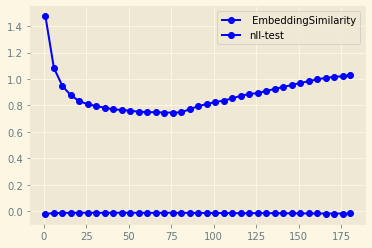

In [ ]:
plot_results_texygen("seqgan", "real")